In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm

In [220]:
# plotting settings
fm.fontManager.addfont('../references/cmunorm.ttf')
matplotlib.rcParams['font.family'] = 'CMU Concrete'
plt.rc('axes', unicode_minus=False)

## Data for QGIS DistanceCartogram transformations

In [2]:
# main data with places/dates
main_df = pd.read_csv('../data/processed_data.tsv', sep='\t', encoding='utf8', na_values=pd.NA).convert_dtypes()
main_df.doc_date = pd.to_datetime(main_df.doc_date)
main_df.origin_date = pd.to_datetime(main_df.origin_date)
main_df = main_df[main_df.delta.isin(range(0,120))]

In [5]:
# coordinates
places = pd.read_csv('../data/places.tsv', sep='\t', encoding='utf8')
places['freq'] = [len(main_df[main_df.placename==name]) for name in places.placename]

In [6]:
# average times for all locations by year
delta = pd.read_csv('../data/average_times.tsv', sep='\t', encoding='utf8', index_col='Unnamed: 0', na_values=pd.NA)

In [208]:
# GeoPandas DataFrame from the coordinates
gdf_base = gpd.GeoDataFrame(places, geometry=gpd.points_from_xy(places.longitude, places.latitude), crs='EPSG:4326')
gdf_base.to_crs(crs='ESRI:102014', inplace=True) # projection used for my visualisations

In [236]:
# extract Riga for point of reference
riga = gdf_base.loc[gdf_base.placename=='Riga', 'geometry'].values[0]
gdf_base['distance_to_riga'] = np.round(gdf_base.geometry.distance(riga)/1000).astype(int)

In [221]:
# gets the most frequent places for given timerange, so the transformation maps are based on most complete data
def get_most_frequent_places(timerange, topn):
    return main_df.loc[main_df.doc_date.dt.year.isin(timerange)].placename.value_counts().index[:topn]

# takes in the coordinates of places and moves them according to the average movement time
def transform_points(gdf, timerange, topn, exclude=[], save=False):
    
    df = gdf.copy()
    
    # define riga and drop it from calculations
    riga = df.loc[df.placename=='Riga', 'geometry'].values[0]
    df.drop(df[df.placename == 'Riga'].index, inplace=True)
    # distances to riga in km from each location
    df['distance_to_riga'] = np.round(df.geometry.distance(riga)/1000).astype(int)
    
    # places that will be on the map
    places = [place for place in get_most_frequent_places(timerange, topn) if place not in exclude]
    placename_id_dict = dict(zip(places, range(len(places)))) # for adding numerical id column later
    
    start = timerange[0]
    stop = timerange[-1]
    
    # get the average movement speeds during the timerange
    means = delta.loc[start:stop].mean().dropna()[places]
    
    # generate a movement time column
    df['delta'] = df['placename'].apply(lambda x: means[x] if x in places else pd.NA)
    df.dropna(subset='delta', inplace=True)
    
    # get occurrence counts for all placenames within the timerange
    df['freq'] = df.placename.apply(lambda name: len(main_df[main_df.doc_date.dt.year.isin(timerange) & (main_df.placename == name)]))
    
    # average speed for each location and across all locations
    df['avg_speed'] = df['distance_to_riga']/df['delta']
    total_avg_speed = df['avg_speed'].mean()
    
    # weighted distance = time * average movement speed across all locations
    df['distance_transformed'] = df['delta']*total_avg_speed
    
    # calculating the new coordinates
    df['PB'] = riga.y - df.geometry.y
    df['VB'] = riga.x - df.geometry.x
    df['V_B_'] = df['VB'] * df['distance_transformed'] / df['distance_to_riga']
    df['PB_'] = df['PB'] * df['distance_transformed'] / df['distance_to_riga']
    df['X_new'] = riga.x - df['V_B_']
    df['Y_new'] = riga.y - df['PB_']
    
    
    # create Dataframes for new coordinates (points_t) and old coordinates (with minimum necessary info, points)
    points_t = gpd.GeoDataFrame(data={'placename': df.placename, 'longitude': df['X_new'], 'latitude': df['Y_new'], 'freq': df['freq']},
                                geometry=gpd.points_from_xy(df['X_new'], df['Y_new']))
    points_t = points_t.append({'placename': 'Riga', 'longitude': riga.x, 'latitude': riga.y, 'geometry': riga}, ignore_index=True)
    points_t['id'] = points_t.placename.apply(lambda name: placename_id_dict[name])
    
    
    points = gpd.GeoDataFrame(data={'placename': df.placename, 'longitude': df.geometry.x, 'latitude': df.geometry.y, 'freq': df['freq']},
                               geometry=gpd.points_from_xy(df.geometry.x, df.geometry.y))
    points = points.append({'placename': 'Riga', 'longitude': riga.x, 'latitude': riga.y}, ignore_index=True)
    points['id'] = points.placename.apply(lambda name: placename_id_dict[name])
    
    
    if save:
        if alpha:
            points_t.to_csv(f"../qgis/points_transformed_{start}_{stop}_alpha_{str(alpha).replace('.', '')}.tsv",
                            sep='\t', encoding='utf8')
            points.to_csv(f"../qgis/points_{start}_{stop}_alpha_{str(alpha).replace('.', '')}.tsv",
                          sep='\t', encoding='utf8')
            
        else:
            points_t.to_csv(f"../qgis/points_transformed_{start}_{stop}.tsv",
                            sep='\t', encoding='utf8')
            points.to_csv(f"../qgis/points_{start}_{stop}.tsv",
                          sep='\t', encoding='utf8')
    
    return points, points_t

In [222]:
points, points_transformed = transform_points(gdf_base, range(1860, 1889), 100, save=False,
                                             exclude=['New York', 'Türkische Grenze', 'Washington', 'Bombay'])

C:\Users\krister\AppData\Local\Temp\ipykernel_14092\3929966329.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  points_t = points_t.append({'placename': 'Riga', 'longitude': riga.x, 'latitude': riga.y, 'geometry': riga}, ignore_index=True)
C:\Users\krister\miniconda3\envs\geo\lib\site-packages\pandas\core\dtypes\cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\krister\AppData\Local\Temp\ipykernel_14092\3929966329.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  points = points.append({'placename': 'Riga', 'longitude': riga.x, 'latitude': riga.y}, ignore_index=True)


## Maps of Europe and the world

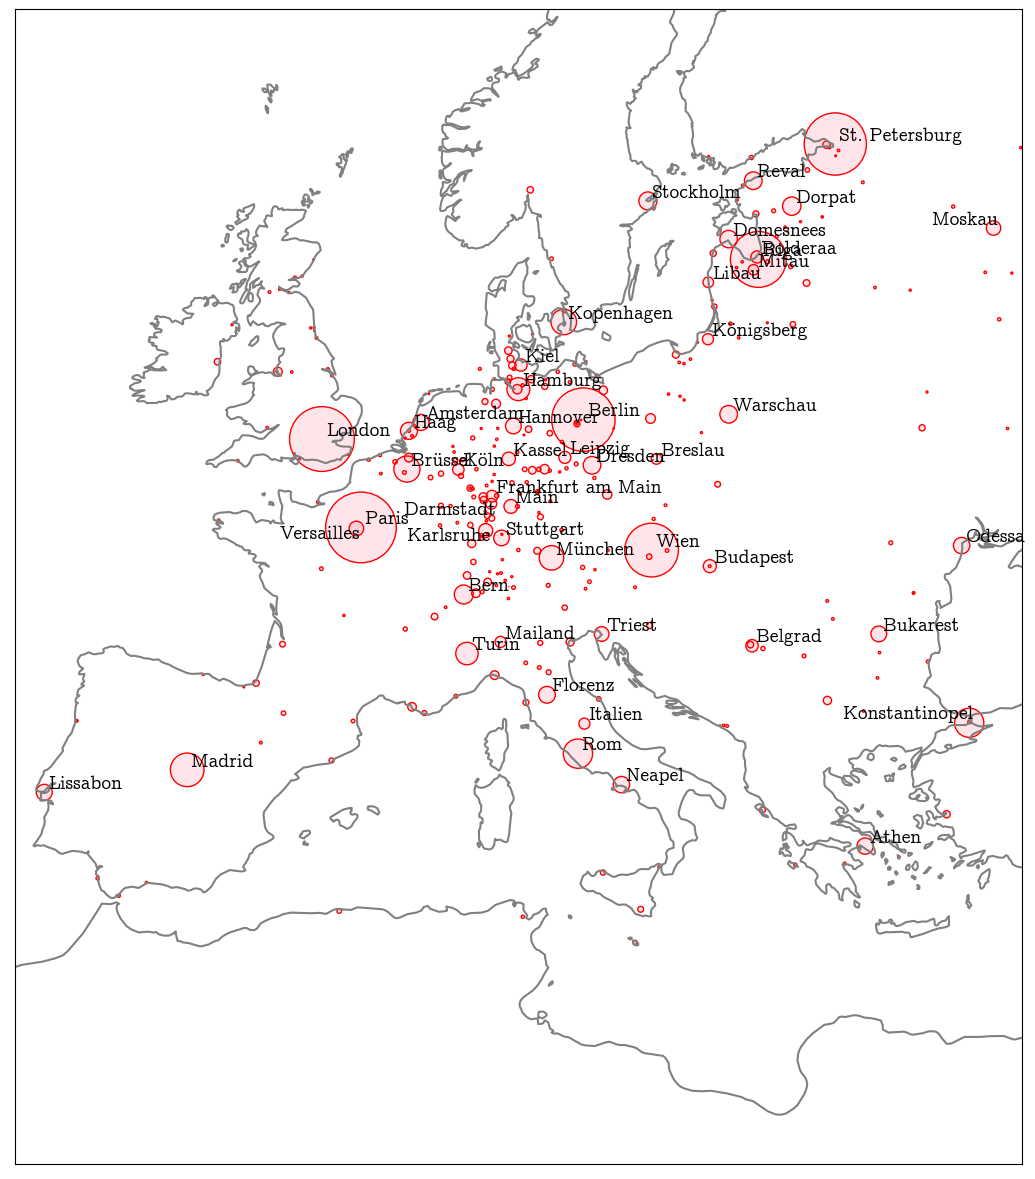

In [226]:
def plot_europe(gdf, land, min_freq, savepath=None):    
    
    fig, ax = plt.subplots(figsize=(15,15))
    
    land.boundary.plot(ax=ax, color='grey')
    
    gdf.plot(ax=ax, markersize=gdf['freq']/10, edgecolor='red', facecolor=(1, 0, 0.2, 0.1))

    for x, y, freq, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.freq, gdf.placename):
        if freq > min_freq:
            if x > 1560320:
                ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", ha='right', fontsize=14)
            elif label in ['Versailles', 'Karlsruhe', 'Darmstadt']:
                ax.annotate(label, xy=(x, y-50000), xytext=(3, 3), textcoords="offset points", ha='right', fontsize=14)
            else:
                ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=14)
        #elif freq < min_freq and freq > min_freq/2:
        #    if x > 1560320:
        #        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", ha='right', fontsize=10)
        #    else:
        #        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=10)

    ax.set_xlim(-1771030.9557765622, 1771059.394568238)
    ax.set_ylim(-83913.47395288725, 3977831.559172161)
    #ax.set_xlim(-30, 70)
    #ax.set_ylim(20,70)

    plt.xticks([])
    plt.yticks([])
    
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
        
    plt.show()
    
    
plot_europe(gdf_base, land, 500)
#savepath='../references/images/europe.png')

In [241]:
# import world map
land = gpd.read_file('../qgis/shapefiles/ne_50m_land.zip')
land.to_crs(crs='ESRI:102014', inplace=True)

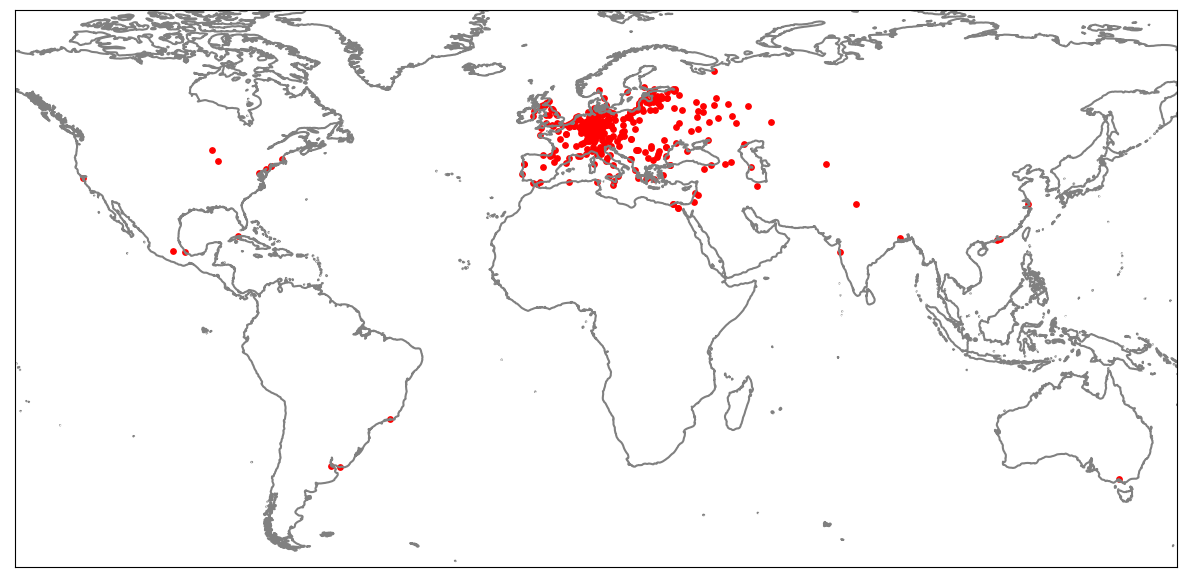

In [230]:
def plot_world(gdf, land, min_freq, savepath=None):
    
    plot_gdf = gdf.to_crs(crs='EPSG:4326')
    plot_land = gpd.read_file('../data/geo/ne_50m_land.zip')
    
    fig, ax = plt.subplots(figsize=(15,10))
    
    plot_land.boundary.plot(ax=ax, color='grey') 
    plot_gdf.plot(ax=ax, markersize=15, color='red')


    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.set_xlim(-140, 160)
    ax.set_ylim(-60, 80)

    plt.xticks([])
    plt.yticks([])
    
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
        
    plt.show()
    
    
plot_world(gdf_base, land, 1000)
           #savepath='../references/images/world.png')

## Distance vs time plots

In [232]:
def plot_distance_and_time(timerange, min_freq, df=gdf_base, delta=delta, labels=[], savepath=None, log=False):
    
    if 'distance_to_riga' not in df.columns:
        riga = df.loc[df.placename=='Riga', 'geometry'].values[0]
        df.drop(df[df.placename == 'Riga'].index, inplace=True)
        df['distance_to_riga'] = np.round(df.geometry.distance(riga)/1000).astype(int)
    
    means = delta.loc[timerange[0]:timerange[-1]].mean().dropna()
    df['delta'] = df['placename'].apply(lambda x: means[x] if x in means.index else pd.NA)
    df.dropna(subset='delta', inplace=True)
    df.drop(df[df.placename == 'Riga'].index, inplace=True)
    
    for name in df.sort_values(by='delta', ascending=False).placename.values[:10]:
        labels.append(name)
        
    fig, ax = plt.subplots(figsize=(15,5))

    ax.scatter(x=df['distance_to_riga'], y=df['delta'])
    ax.grid()
    plt.xticks(size=14)
    plt.yticks(size=14)
    
    if log:
        ax.set_xscale('log')
    else:
        x.set_xlim(-1000, 19000)

    ax.set_ylim(-10, 100)

    plt.xlabel('distance (km)', size=16)
    plt.ylabel('days', size=16)
    
    for name, x, y, freq in zip(df.placename, df.distance_to_riga, df.delta, df.freq):
        if freq >= min_freq or name in labels:
            ax.annotate(name, (x, y), fontsize=12)
            
    plt.title(f'Distance and speed of news to Riga, {timerange[0]}-{timerange[-1]}', fontsize=18)
            
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
                
    plt.show()

In [238]:
custom_labels = list(gdf_base.sort_values(by='distance_to_riga', ascending=False).placename.values[:10])

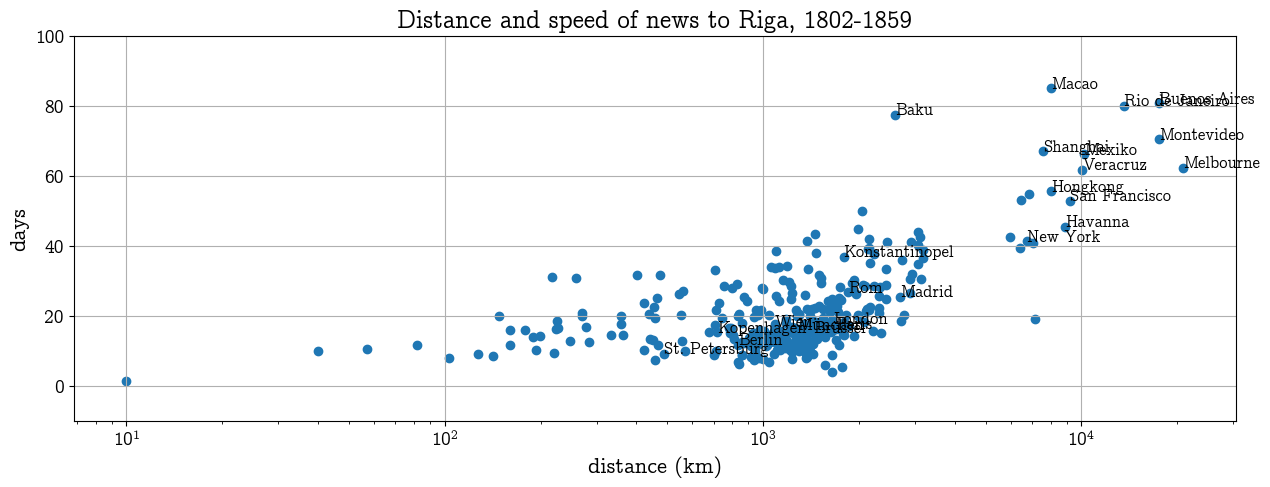

In [239]:
plot_distance_and_time(range(1802, 1860), 3000, gdf_base, delta, labels=custom_labels, log=True)
                      #savepath='../references/images/dist_speed_early.png')

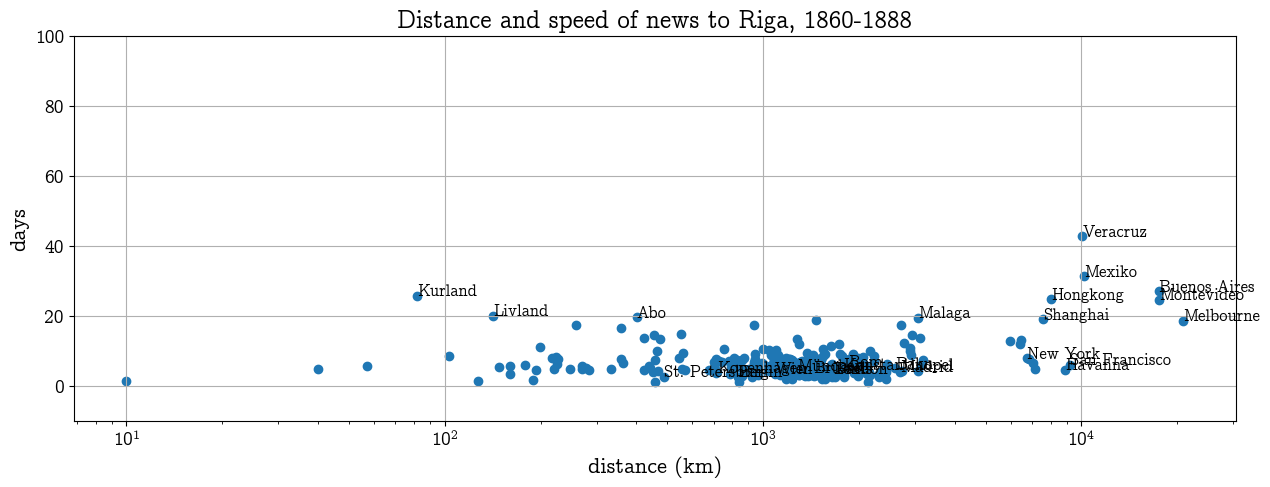

In [240]:
plot_distance_and_time(range(1860, 1889), 3000, gdf_base, delta, labels=custom_labels, log=True)
                      #savepath='../references/images/dist_speed_late.png')